<div style="text-align: center;">
  <h1>Marathon Training Performance & Recovery Dashboard</h1>
  <h4>Developed by Timothy Berlanga</h4>
</div>
<h4 style="text-align: center;">A Data-Driven Approach to Enhance Endurance and Optimize Recovery</h4>
<p style="text-align: center;">
  <strong>Link to Repository</strong>: <a href="https://github.com/TimB21/Marathon-Training-Performance-and-Recovery-Dashboard" target="_blank">Marathon Training Performance and Recovery Dashboard</a>
</p>


## Table of Contents  
<ul>
  <li><a href="#introduction">Introduction</a></li>
  <li><a href="#30-day-run-log">30 Day Running Log</a></li>
  <li><a href="#distance-over-the-past-week-month-3-months">Distance Over the Past week, month, and 3 months</a></li>
  <li><a href="#weekly-and-monthly-mileage-calculations">Weekly and Monthly Mileage Calculations</a></li>
  <li><a href="#the-journey-to-1000-miles">Journey to 1000 Miles</a></li>
  <li><a href="#pace-and-heart-rate-analysis">Pace and Heart Rate Analysis</a></li>
  <li><a href="#performance-score">Performance Scores</a></li>
    <li><a href="#top-10-performances">Top 10 Performance</a></li>
  <li><a href="#training-stress-score-tss">Training Stress Score (TSS)</a></li>
  <li><a href="#acute-chronic-training-load">Acute and Chronic Training Load</a></li>
  <li><a href="#stress-rest-ratio">Acute vs Chronic Training Loads (Stress/Rest Ratio)</a></li>
  <li><a href="#intensity-factor-if">Intensity Factor (IF)</a></li>
  <li><a href="#training-peaks">Training Peaks</a></li>
  <li><a href="#machine-learning-analysis">Machine Learning Integration</a></li>
</ul>


<h3 id="introduction">Introduction</h3>


### Objective
The Marathon Training Performance & Recovery Dashboard is a comprehensive data analysis tool designed to track, analyze, and visualize key metrics for marathon training. By leveraging interactive visualizations and performance-based insights, this tool has helped me optimize my training regimen, prevent overtraining, and improve peak workout performance.

### Advanced Features
- **Pace Analysis**: Evaluates trends in running pace over days, weeks, and months to monitor progress.
- **Heart Rate Monitoring**: Visualizes heart rate patterns to assess training intensity and cardiovascular efficiency.
- **Performance Metrics**: Generates a custom performance score combining pace, heart rate, and distance for holistic evaluation.
- **Mileage Tracking**: Tracks cumulative and monthly mileage to ensure gradual progression and prevent injuries.
- **Training Stress Score (TSS)**: Calculates and visualizes the intensity of training sessions using duration, pace, and functional threshold power.
- **Load Balancing**: Analyzes Acute Training Load (ATL) and Chronic Training Load (CTL) to ensure proper balance between effort and recovery.
- **Machine Learning Integration:** Leverages clustering techniques to identify training patterns and classify workout types based on pace and heart rate data Uses regression models to predict future performance metrics and optimize training plans for sustained improvement.

### Purpose
This tool was created to:
- Assist in personal marathon training for the Austin Marathon by providing actionable insights into performance and recovery.
- Demonstrate advanced skills in Python, data visualization, and user-friendly dashboard design.

In [96]:
import pandas as pd
import numpy as np

# Load the CSV data
file_path = 'RunningData.csv' 

try:
    df = pd.read_csv(file_path, header=0)  # First row is used as header
    # print("Preview of raw data:")
    # print(df.head(10))  # Print the first 10 rows to check structure

except Exception as e:
    print(f"An error occurred while reading the file: {e}")

# Proceed only if the DataFrame is loaded successfully
if df is not None and not df.empty:
    # Clean and process the DataFrame
    # Strip any leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()

    # Define the cleaning function for time format
    def clean_time_format(time_str):
        if pd.isna(time_str):
            return time_str  # Return NaN as is
        parts = time_str.split(':')
        # If there are only two components (mm:ss), add "00:" in front
        if len(parts) == 2:
            return f"00:{time_str}"
        # If there are three components (hh:mm:ss), return as is
        return time_str

    # Apply the cleaning function to the 'Time' column
    if 'Time' in df.columns:
        df['Cleaned Time'] = df['Time'].apply(clean_time_format)
    else:
        print("Column 'Time' is missing. Skipping time-related processing.")

# Create a new column for Total Seconds (handling the new logic for minutes/hours determination)
def calculate_total_seconds(time_str):
    if pd.isna(time_str):
        return None  # Return None for NaN

    parts = time_str.split(':')
    
    # If the first part is greater than or equal to 5, we assume it's hh:mm:ss format
    if len(parts) == 3:
        first_part = int(parts[0])  # The first part (minutes or hours)
        
        # If the first part is greater than or equal to 5, treat it as hours:minutes:seconds
        if first_part <= 5:
            hours, minutes, seconds = map(int, parts)
            total_seconds = hours * 3600 + minutes * 60 + seconds
        else:
            # Otherwise, it's in mm:ss:SSS format (minutes:seconds:milliseconds)
            minutes, seconds, milliseconds = map(int, parts)
            total_seconds = minutes * 60 + seconds + milliseconds / 1000
        return total_seconds
    
    # If the format doesn't match, return None
    return None

# Apply the cleaning function to the 'Cleaned Time' column
if 'Cleaned Time' in df.columns:
    df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

# Check the DataFrame with the new columns
if 'Total Seconds' in df.columns:
    # print("Preview of updated DataFrame with new columns:")
    # print(df[['Time', 'Cleaned Time', 'Total Seconds']])

    if 'Cleaned Time' in df.columns:
        df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Convert necessary columns to appropriate data types
    if 'Distance' in df.columns:
        df['Distance'] = df['Distance'].str.replace(' mi', '').astype(float)
    else:
        print("Column 'Distance' is missing. Skipping distance conversion.")

    if 'Heart Rate' in df.columns:
        df['Heart Rate'] = df['Heart Rate'].astype(int)
    else:
        print("Column 'Heart Rate' is missing. Skipping heart rate conversion.")

    # # Final DataFrame preview
    # print("Final processed DataFrame:")
    # print(df.head())

    # Calculate pace in miles per hour
    def calculate_pace(df):
        """
        Calculates the pace in miles per hour (mph) for each row in the DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing running data with 'Total Seconds' and 'Distance' columns.

        Returns:
            pd.DataFrame: DataFrame with a new column 'Pace (mph)' representing the pace in miles per hour.
        """
        # Ensure that the required columns are available
        if 'Total Seconds' not in df.columns or 'Distance' not in df.columns:
            print("Missing necessary columns for pace calculation.")
            return df
        
        # Calculate pace in miles per hour: pace = distance (in miles) / time (in hours)
        # Convert Total Seconds to hours by dividing by 3600 (seconds in an hour)
        df['Pace (mph)'] = df['Distance'] / (df['Total Seconds'] / 3600)
        
        return df

    # Apply the pace calculation function to the DataFrame
    if df is not None:
        df = calculate_pace(df)

        # # Check the DataFrame with the new 'Pace (mph)' column
        # print("\nDataFrame with calculated pace:")
        # print(df[['Distance', 'Total Seconds', 'Pace (mph)']].head())

else:
    print("Data loading failed or resulted in an empty DataFrame. Check the file content and delimiter.")

# Clean the Elevation column by removing the 'ft' suffix and converting to numeric values
df['Elevation'] = pd.to_numeric(df['Elevation'].str.replace(' ft', '', regex=False), errors='coerce')


<h3 id="30-day-run-log">30 Day Run Log</h3>

In [97]:
# Calculate pace in miles per hour

def calculate_pace(df):
    """
    Calculates the pace in miles per hour (mph) for each row in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing running data with 'Total Seconds' and 'Distance' columns.

    Returns:
        pd.DataFrame: DataFrame with a new column 'Pace (mph)' representing the pace in miles per hour.
    """
    # Ensure that the required columns are available
    if 'Total Seconds' not in df.columns or 'Distance' not in df.columns:
        print("Missing necessary columns for pace calculation.")
        return df
    
    # Calculate pace in miles per hour: pace = distance (in miles) / time (in hours)
    # Convert Total Seconds to hours by dividing by 3600 (seconds in an hour)
    df['Pace (mph)'] = df['Distance'] / (df['Total Seconds'] / 3600)

    df['Pace (min/mile)'] = 60 /  df['Pace (mph)']

    # Convert the decimal pace to a formatted time string
    def format_pace(pace):
        if pace > 0:
            minutes = int(pace)  # Get the whole minutes
            seconds = int((pace - minutes) * 60)  # Get the remaining seconds
            return f"{minutes}:{seconds:02d}"  # Format as 'MM:SS'
        return "0:00"  # Handle edge cases like zero distance
    
    df['Pace (min/mile)'] = df['Pace (min/mile)'].apply(format_pace)


    
    return df

# Apply the pace calculation function to the DataFrame
if df is not None:
    df = calculate_pace(df)

    # # Check the DataFrame with the new 'Pace (mph)' column
    # print("\nDataFrame with calculated pace:")
    # print(df[['Distance', 'Total Seconds', 'Pace (mph)']].head())

past_30 = df.head(30)

past_30 = past_30.drop(columns=['Pace'])
# past_30 = past_30.iloc[::-1]
# Display the last 30 entries of the DataFrame
# display(past_30)

In [98]:
from IPython.display import display, HTML

# Convert the DataFrame to HTML and wrap it in a centered div
html_table = past_30.to_html(classes='dataframe', index=False)
centered_html = f"""
<div style="text-align: center;">
    {html_table}
</div>
"""

# Display the centered DataFrame
display(HTML(centered_html))

Sport,Date,Title,Time,Distance,Elevation,Heart Rate,Cleaned Time,Total Seconds,Pace (mph),Pace (min/mile)
Run,"Sat, 1/18/2025",Lose My Mind,2:52:42,20.25,377,170,2:52:42,10362,7.035321,8:31
Run,"Fri, 1/17/2025",Ohh yeahhh,1:03:48,7.00,138,166,1:03:48,3828,6.583072,9:06
Run,"Wed, 1/15/2025",Rock Your Body,1:10:51,9.00,148,181,1:10:51,4251,7.621736,7:52
Run,"Tue, 1/14/2025",Night Run,1:11:44,7.00,121,160,1:11:44,4304,5.855019,10:14
Run,"Mon, 1/13/2025",Chilly Progression,1:03:38,8.01,106,183,1:03:38,3818,7.552645,7:56
Run,"Sun, 1/12/2025",Welcome to the People,1:13:57,7.40,163,160,1:13:57,4437,6.004057,9:59
Run,"Sat, 1/11/2025",Afraid to Feel,1:40:20,13.11,289,184,1:40:20,6020,7.839867,7:39
Run,"Thu, 1/9/2025",Recovery,1:11:39,7.52,0,150,1:11:39,4299,6.297278,9:31
Run,"Wed, 1/8/2025",Barbra Streisand,1:20:24,10.50,166,180,1:20:24,4824,7.835821,7:39
Run,"Tue, 1/7/2025",Breezy,1:14:19,7.50,240,152,1:14:19,4459,6.055169,9:54


<h3 id="distance-over-the-past-week-month-3-months">Distance Over the Past Week, Month, and 3 Months</h3>
Monitoring distance over the past 7, 30, and 90 days helps me evaluate my training consistency and progression. It ensures that I am building mileage gradually, avoiding injury, and staying on track with my marathon preparation goals. Tracking these trends also highlights periods of overtraining or recovery, helping me balance effort and rest for optimal performance.

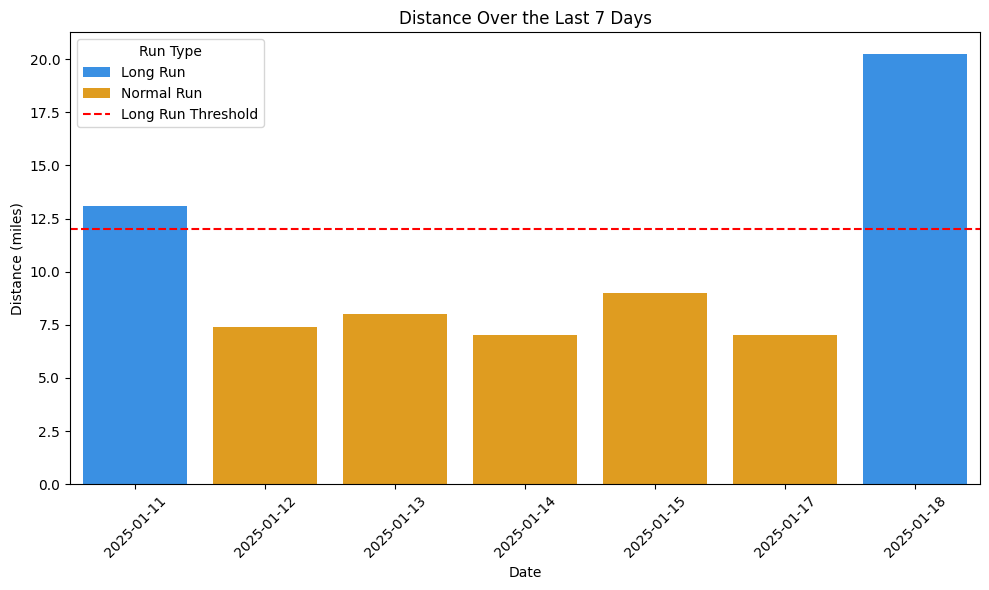

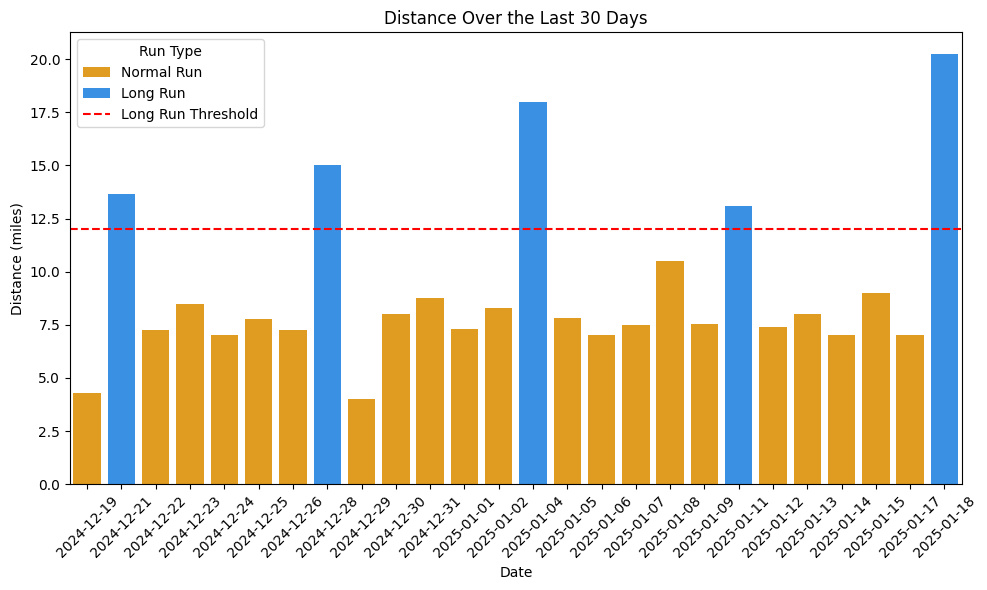

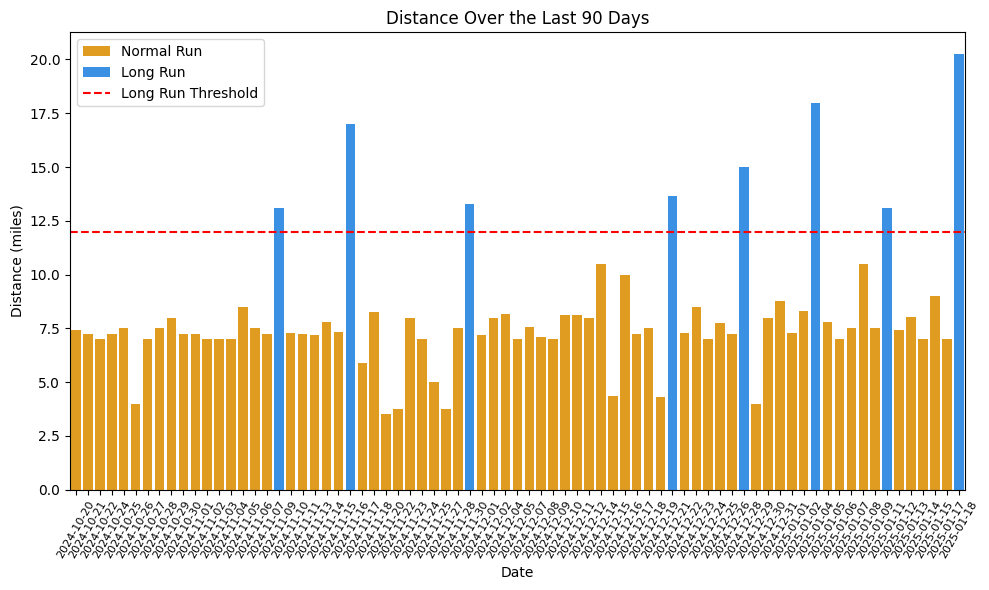

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Date' is in datetime format and sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Get the most recent date in the DataFrame
most_recent_date = df['Date'].max()

# Function to filter data for the last X days
def filter_last_days(df, days):
    return df[df['Date'] >= most_recent_date - pd.Timedelta(days=days)]

def plot_distance_rate(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average distance for each day
    daily_distance_rate = last_days.groupby('Date')['Distance'].mean().reset_index()
    
    # Add a new column to categorize runs
    daily_distance_rate['Run Type'] = daily_distance_rate['Distance'].apply(
        lambda distance: 'Normal Run' if distance <= 12 else 'Long Run'
    )
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Date', 
        y='Distance', 
        hue='Run Type', 
        data=daily_distance_rate, 
        palette={'Normal Run': '#FFA500', 'Long Run': '#1E90FF'},
        dodge=False  # Ensures bars are not separated by hue
    )
    
    # Add a horizontal line at y=12 to indicate the threshold for long runs
    plt.axhline(y=12, color='r', linestyle='--', label='Long Run Threshold')
    
    plt.title(f'Distance Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Distance (miles)')
    plt.xticks(rotation=45)
    plt.legend(title="Run Type")  # Show the legend for the run type
    plt.tight_layout()
    plt.show()



# Plot heart rate for the last 7, 30, and 90 days
plot_distance_rate(df, 7, "Last 7 Days")
plot_distance_rate(df, 30, "Last 30 Days")


# Filter data for the last 90 days
last_days = filter_last_days(df, 90)

# Group by date and calculate the average heart rate for each day
daily_distance_rate = last_days.groupby('Date')['Distance'].mean().reset_index()

 # Add a new column to categorize runs
daily_distance_rate['Run Type'] = daily_distance_rate['Distance'].apply(
        lambda distance: 'Normal Run' if distance <= 12 else 'Long Run'
)
    
plt.figure(figsize=(10, 6))
sns.barplot(
        x='Date', 
        y='Distance', 
        hue='Run Type', 
        data=daily_distance_rate, 
        palette={'Normal Run': '#FFA500', 'Long Run': '#1E90FF'},
        dodge=False  # Ensures bars are not separated by hue
)
    
# Add a horizontal line at y=12 to indicate the threshold for long runs
plt.axhline(y=12, color='r', linestyle='--', label='Long Run Threshold')
    

# Set the plot title and labels
plt.title('Distance Over the Last 90 Days')
plt.xlabel('Date')
plt.ylabel('Distance (miles)')

# Rotate and reduce the font size of date labels
plt.xticks(rotation=60, fontsize=8)

# Add legend and layout adjustments
plt.legend()
plt.tight_layout()
plt.show()


<h3 id="weekly-and-monthly-mileage-calculations">Weekly and Monthly Mileage Calculations</h3>

Calculating weekly and monthly mileage provides a clear picture of my overall training volume and progression. By tracking these metrics, I can ensure I'm gradually increasing my workload to build endurance while minimizing the risk of injury. These calculations also help me assess if I'm meeting my marathon preparation targets and allow me to make data-driven adjustments to maintain consistent performance and recovery balance.

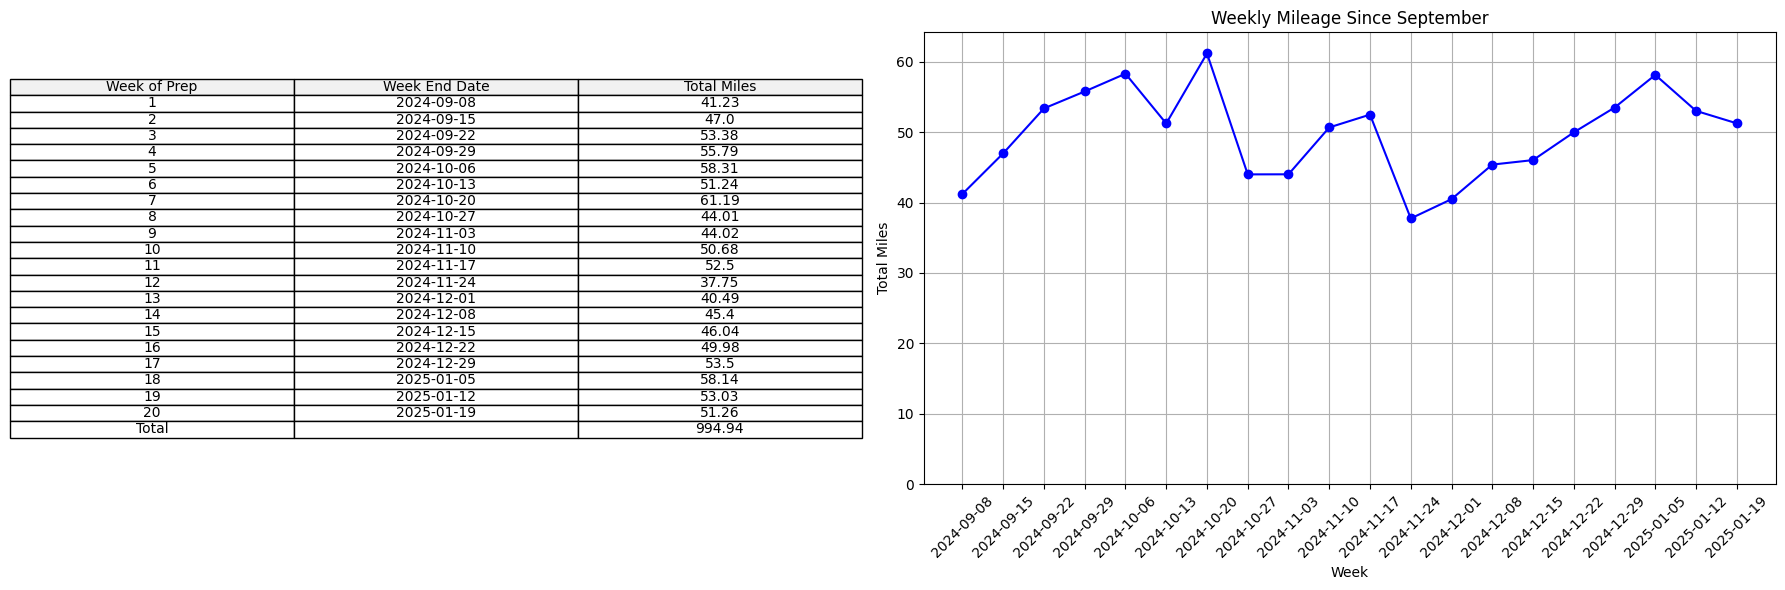

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

# Filter for runs since September 1
df_filtered = df[df['Date'] >= '2024-09-01']

# Set the Date column as the index for easier grouping
df_filtered.set_index('Date', inplace=True)

# Group by week and calculate the total mileage
weekly_mileage = df_filtered['Distance'].resample('W').sum().reset_index()

# Rename columns for clarity
weekly_mileage.columns = ['Week End Date', 'Total Miles']

# Add a column for row numbers (index) starting from 1
weekly_mileage.insert(0, 'Week of Prep', range(1, len(weekly_mileage) + 1))

# Clean the weekly mileage data
weekly_mileage['Total Miles'] = weekly_mileage['Total Miles'].round(2)  # Round to 2 decimal places

# Clean the Week column to display only the date part, without the time (00:00:00)
weekly_mileage['Week End Date'] = weekly_mileage['Week End Date'].dt.strftime('%Y-%m-%d')  # Format as 'YYYY-MM-DD'

# Clean the Week column to display only the date part, without the time (00:00:00)
cleaned_weekly_mileage = weekly_mileage.copy()

# Calculate the total for the 'Total Miles' column
total_row = pd.DataFrame({
    'Week of Prep': ['Total'],
    'Week End Date': [''],
    'Total Miles': [weekly_mileage['Total Miles'].sum()]
})

# Append the total row to the dataframe
weekly_mileage = pd.concat([weekly_mileage, total_row.round(2)], ignore_index=True)

# Now create the plot and table as before
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Display the weekly mileage table on the first axis (ax[0])
ax[0].axis('off')  # Hide the axis

# Create a table within ax[0]
table = ax[0].table(cellText=weekly_mileage.values, colLabels=weekly_mileage.columns, loc='center', cellLoc='center', colColours=['#f1f1f1']*len(weekly_mileage.columns))

# Style the table (optional)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1)

# Plot the weekly mileage on the second axis (ax[1])
ax[1].plot(cleaned_weekly_mileage['Week End Date'], cleaned_weekly_mileage['Total Miles'], marker='o', linestyle='-', color='b')
ax[1].set_title('Weekly Mileage Since September')
ax[1].set_xlabel('Week')
ax[1].set_ylabel('Total Miles')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylim(0, cleaned_weekly_mileage['Total Miles'].max() + 3)  # Set y-axis to start from 0, add buffer for clarity
ax[1].grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

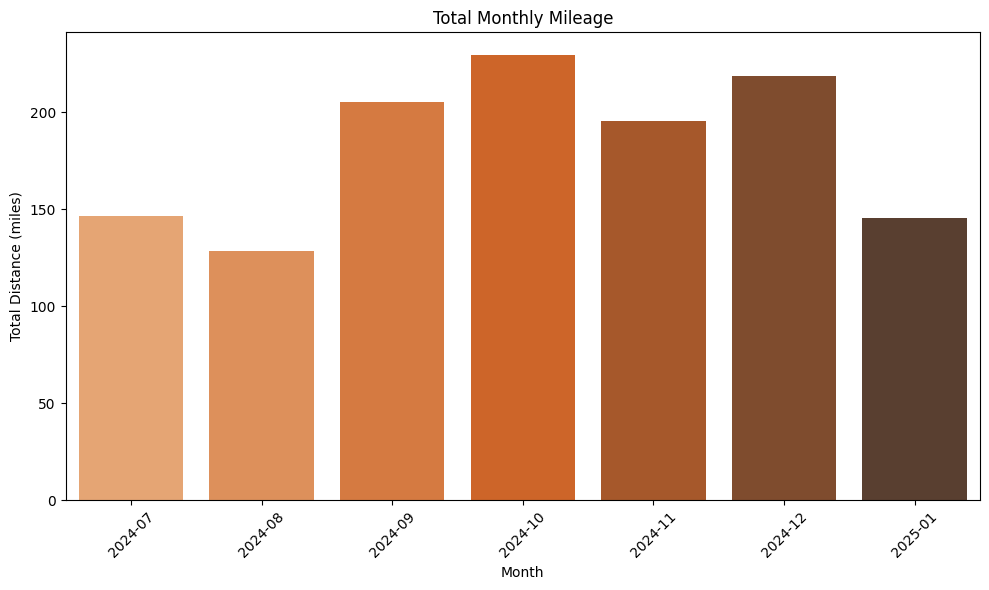

In [ ]:
# Assuming df is already loaded and 'Date' is in string format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert 'Date' to datetime

# Filter data for the past 6 months, starting from July 1st
start_of_july = pd.to_datetime('2024-07-01')  # Set the start date to July 1st, 2024
df_last_6_months = df[df['Date'] >= start_of_july].copy()  # Use .copy() to avoid modifying the slice

# Now, use .loc to avoid the SettingWithCopyWarning
df_last_6_months.loc[:, 'Year-Month'] = df_last_6_months['Date'].dt.to_period('M')

# Group by 'Year-Month' and sum the distance for each month
monthly_mileage = df_last_6_months.groupby('Year-Month')['Distance'].sum().reset_index()

# Sort by 'Year-Month'
monthly_mileage = monthly_mileage.sort_values('Year-Month')

# Plotting the monthly mileage bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Year-Month', y='Distance', data=monthly_mileage, hue='Year-Month', palette='Oranges_d', legend=False)
plt.title('Total Monthly Mileage')
plt.xlabel('Month')
plt.ylabel('Total Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3 id="the-journey-to-1000-miles">The Journey to 1000 Miles</h3>

September 1st marked the beginning of training for the Austin Marathon. My goal for the prep was to accumulate 1000 miles. This graph is a reminder of how far I've come since the start. It's been a huge encoruagement. 

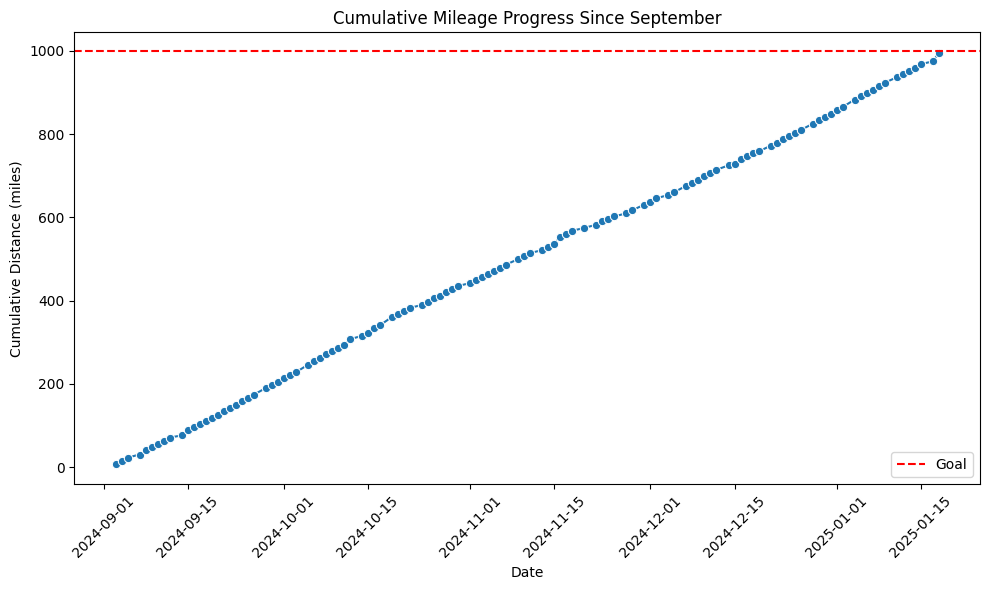

In [ ]:
# Filter data since September
september_start = pd.to_datetime('2024-09-01')  
df_since_september = df[df['Date'] >= september_start]

# Group by date and sum the distance for each day
daily_mileage = df_since_september.groupby('Date')['Distance'].sum().reset_index()

# Sort by date
daily_mileage = daily_mileage.sort_values('Date')

# Create a cumulative sum of the mileage
daily_mileage['Cumulative Mileage'] = daily_mileage['Distance'].cumsum()

# Plotting the cumulative mileage since September
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Cumulative Mileage', data=daily_mileage, marker='o')
plt.axhline(y=1000, color='r', linestyle='--', label='Goal')
plt.title('Cumulative Mileage Progress Since September')
plt.xlabel('Date')
plt.ylabel('Cumulative Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


<h3 id="pace-and-heart-rate-analysis">Pace and Heart Rate Analysis</h3>

Monitoring pace and heart rate over the past week and month provides critical insights into my marathon training progress. The primary objective is to improve my ability to sustain faster paces over longer distances while maintaining a lower average heart rate—a key indicator of improved endurance and aerobic efficiency.

My target pace for the Austin Marathon is an average of **8:10 minutes per mile**, aiming for a finishing time of approximately **3:34**. This pace provides a buffer for achieving my ultimate goal of a sub-3:40:00 finish. Consistently training at this pace during longer runs helps simulate race conditions and build confidence in hitting my performance targets.

I calculate my recovery heart rate using the **MAF formula**: 180 minus my age. At 21 years old, my recovery threshold is **159 bpm**. On easy days, I aim to keep my average heart rate below this limit to ensure proper recovery and prevent overtraining. In the early stages of my prep, one of my challenges was training too intensely on recovery days, which led to fatigue and reduced performance. I've since prioritized maintaining low-intensity efforts on recovery days, which is critical for achieving high-mileage weeks while minimizing the risk of injury or burnout.

By consistently tracking these metrics, I can fine-tune my training approach, balance effort with recovery, and optimize my performance as race day approaches.


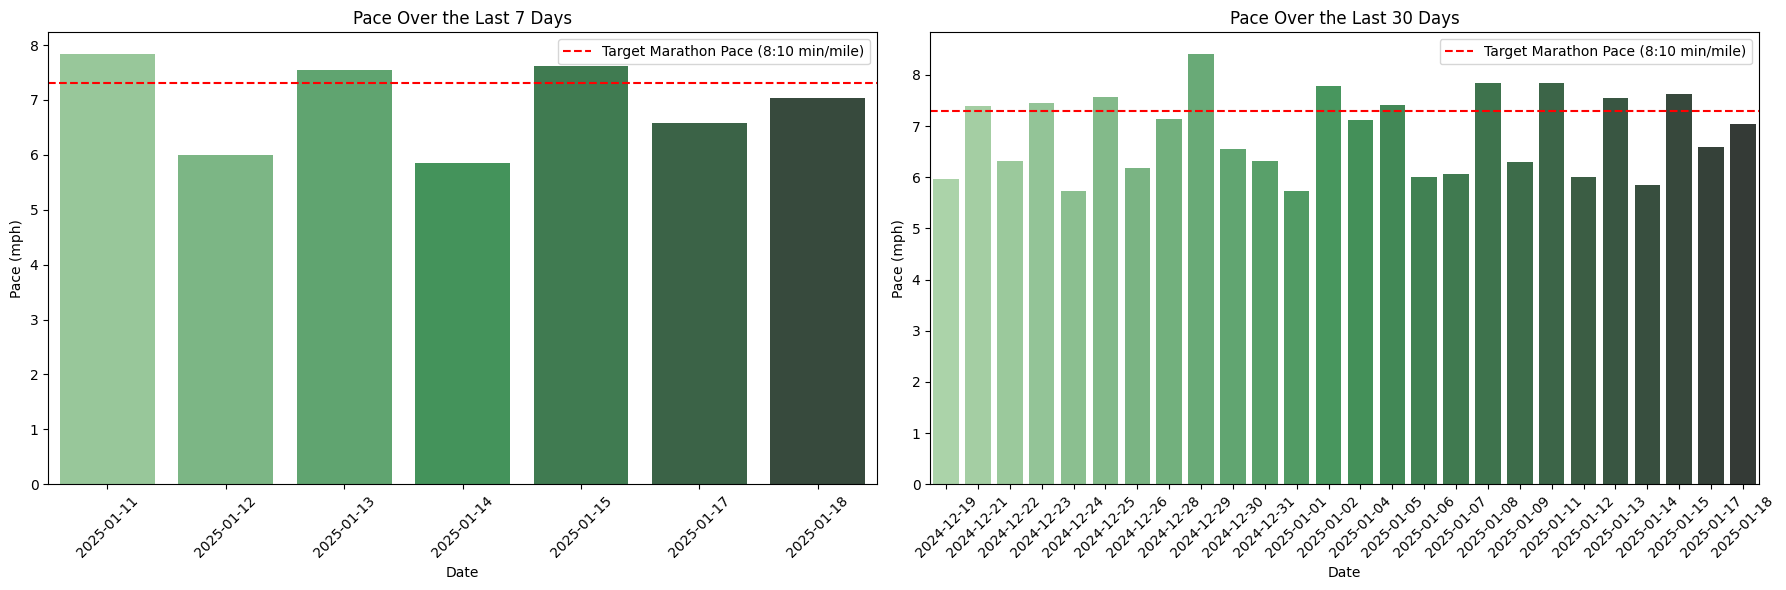

In [ ]:
def plot_pace(df, days, time_period="Last X Days", ax=None):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average pace for each day
    daily_pace = last_days.groupby('Date')['Pace (mph)'].mean().reset_index()
    
    # Use the provided axis (ax) for plotting
    if ax is None:
        ax = plt.gca()
    
    sns.barplot(x='Date', y='Pace (mph)', data=daily_pace, hue='Date', palette='Greens_d', legend=False, ax=ax)
    ax.set_title(f'Pace Over the {time_period}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Pace (mph)')
    ax.axhline(y=7.3, color='r', linestyle='--', label='Target Marathon Pace (8:10 min/mile)')
    ax.legend()  # Show the legend for the line
    ax.tick_params(axis='x', rotation=45)

# Create subplots for 7, 30, and 90 days
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

# Plot pace for the last 7, 30, and 90 days
plot_pace(df, 7, "Last 7 Days", ax=axes[0])
plot_pace(df, 30, "Last 30 Days", ax=axes[1])

plt.tight_layout()  # Adjust layout for better spacing between subplots
plt.show()


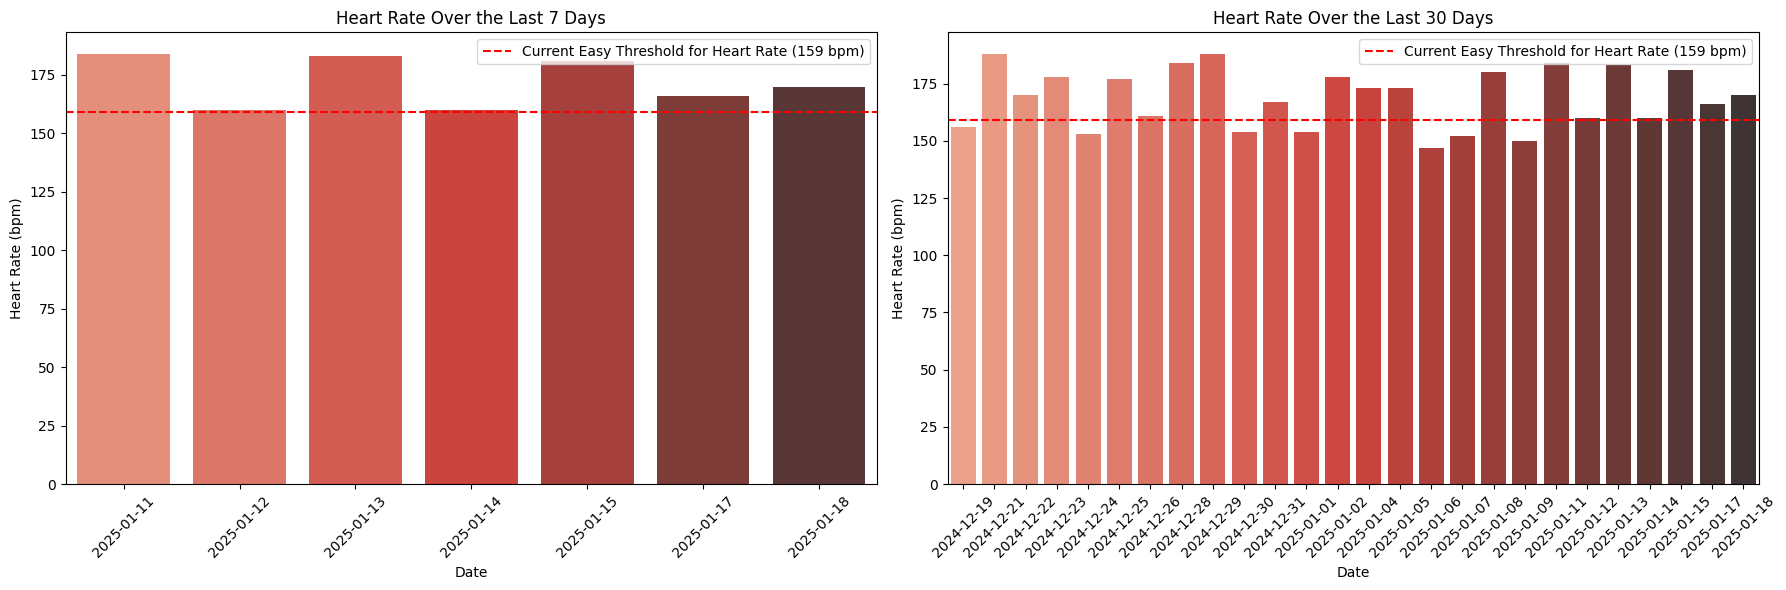

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot bar graph for heart rate over a given period with a horizontal line at 159 bpm
def plot_heart_rate(df, days, time_period="Last X Days", ax=None):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average heart rate for each day
    daily_heart_rate = last_days.groupby('Date')['Heart Rate'].mean().reset_index()
    
    # Use the provided axis (ax) for plotting
    if ax is None:
        ax = plt.gca()
    
    sns.barplot(x='Date', y='Heart Rate', data=daily_heart_rate, hue='Date', palette='Reds_d', legend=False, ax=ax)
    
    # Add a horizontal line at y=159 bpm
    ax.axhline(y=159, color='r', linestyle='--', label='Current Easy Threshold for Heart Rate (159 bpm)')
    
    ax.set_title(f'Heart Rate Over the {time_period}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Heart Rate (bpm)')
    ax.legend()  # Show the legend for the line
    ax.tick_params(axis='x', rotation=45)

# Create subplots for 7, 30, and 90 days
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

# Plot heart rate for the last 7, 30, and 90 days
plot_heart_rate(df, 7, "Last 7 Days", ax=axes[0])
plot_heart_rate(df, 30, "Last 30 Days", ax=axes[1])

plt.tight_layout()  # Adjust layout for better spacing between subplots
plt.show()


In [75]:
# import matplotlib.pyplot as plt

# # Calculate and display correlation for the last 7 days
# correlation_7_days = last_7_days['Pace (mph)'].corr(last_7_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 7 days: {correlation_7_days:.2f}")

# # Calculate and display correlation for the last 30 days
# correlation_30_days = last_30_days['Pace (mph)'].corr(last_30_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 30 days: {correlation_30_days:.2f}")

# # Calculate and display correlation for the last 90 days
# correlation_90_days = last_90_days['Pace (mph)'].corr(last_90_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 90 days: {correlation_90_days:.2f}")
 
# # Scatter Plot: Pace vs Heart Rate for the Last 7 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_7_days)
# plt.correlation = last_7_days['Pace (mph)'].corr(last_7_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 7 Days\nCorrelation: {correlation_7_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Scatter Plot: Pace vs Heart Rate for the Last 30 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_30_days)
# plt.correlation = last_30_days['Pace (mph)'].corr(last_30_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 30 Days\nCorrelation: {correlation_30_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show() 

# # Scatter Plot: Pace vs Heart Rate for the Last 30 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_90_days)
# plt.correlation = last_90_days['Pace (mph)'].corr(last_90_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 90 Days\nCorrelation: {correlation_90_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show() 


<h3 id="performance-score">Performance Score</h3>

The rolling performance score tracks my workout performance over specific periods (7 and 30 days) to provide insights into how consistently I'm improving. By calculating my pace, heart rate, and distance over these intervals, the performance score gives me a clear picture of my training intensity, efficiency, and progress. This helps in identifying trends in my training, ensuring I’m training effectively, and making adjustments when necessary. Below are the rolling performance scores for the past 7 and 30 days.

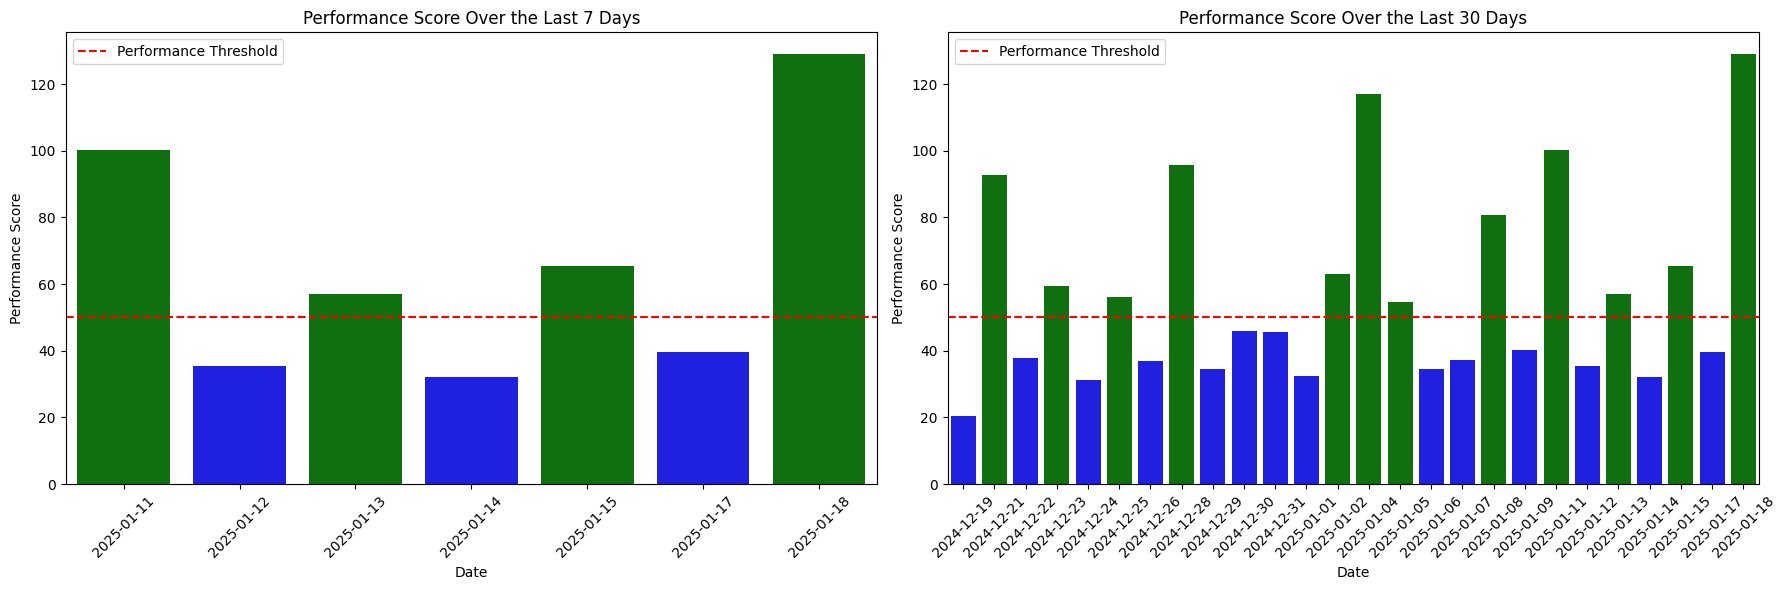

In [104]:
# Function to calculate performance score
def calculate_performance_score(pace, heart_rate, distance):
    if pace == 0 or heart_rate == 0:
        return None  # Handle division by zero

    performance_score = (
        (pace ** 1.9)          # Heavily reward faster paces
        * ((distance ** 1) / 1.3)  # Strongly reward longer distances
        / (heart_rate ** 0.31)  # Minimally penalize higher heart rate
    )
    return performance_score

# Function to plot performance score over a given period with support for subplots
def plot_performance_score(df, days, time_period="Last X Days", ax=None):
    last_days = filter_last_days(df, days)
    
    # Instead of setting directly on the slice, use .loc to avoid the warning
    last_days = last_days.copy()  # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    last_days['Performance Score'] = last_days.apply(
        lambda row: calculate_performance_score(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1
    )
    
    # Group by date and calculate the average performance score for each day
    daily_performance_score = last_days.groupby('Date')['Performance Score'].mean().reset_index()
    
    # Set a performance score threshold (adjust as needed)
    threshold = 50
    
    # Create a list of colors based on the threshold
    colors = ['green' if score > threshold else 'blue' for score in daily_performance_score['Performance Score']]
    
    # Use the provided axis (ax) for plotting
    if ax is None:
        ax = plt.gca()
    
    # Plot bar chart with custom colors based on performance score
    sns.barplot(x='Date', y='Performance Score', data=daily_performance_score, hue='Date', palette=colors, legend=False, ax=ax)
    
    # Add a horizontal line for the performance threshold
    ax.axhline(y=threshold, color='r', linestyle='--', label='Performance Threshold')
    
    # Add title and labels
    ax.set_title(f'Performance Score Over the {time_period}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Performance Score')
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)
    
    # Show the legend for the threshold line
    ax.legend()  

# Create subplots for 7, 30 days
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot performance score for the last 7 and 30 days on separate axes
plot_performance_score(df, 7, "Last 7 Days", ax=axes[0])
plot_performance_score(df, 30, "Last 30 Days", ax=axes[1])

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


<h3 id="top-10-performances">Top 10 Performances</h3>

In this section, I’ve highlighted my top 10 performances based on a custom performance score, which factors in my pace, heart rate, and distance. This score helps me assess the overall quality of my workouts, emphasizing faster paces, longer distances, and efficient heart rate management. By identifying my best performances, I can better track progress and focus on improving in key areas for future runs. Below are the top 10 performances from my running history based on this score.


In [77]:
def display_top_performances(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    # df = df.copy()

    # Apply the performance score function to the data
    df['Performance Score'] = df.apply(
        lambda row: calculate_performance_score(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1
    )

    # Sort by Performance Score in descending order and get the top 10
    top_10_performances = df.sort_values(by='Performance Score', ascending=False).head(10)


    # Convert the DataFrame to HTML and wrap it in a centered div
    html_table = (top_10_performances[['Date', 'Title', 'Distance', 'Pace (min/mile)', 'Heart Rate', 'Performance Score']]).to_html(classes='dataframe', index=False)
    centered_html = f"""
    <div style="text-align: center;">
        {html_table}
    </div>
    """

    # Display the centered DataFrame
    display(HTML(centered_html))

# Display the top 10 performances
display_top_performances(df)

Date,Title,Distance,Pace (min/mile),Heart Rate,Performance Score
2025-01-18,Lose My Mind,20.25,8:31,170,129.086848
2024-10-19,GINOBILI,20.01,8:47,162,122.193886
2024-10-05,Get Lucky,18.01,8:27,168,117.149035
2025-01-04,Wins & Loses,18.00,8:24,173,117.018895
2024-11-16,POWER,17.01,8:26,173,109.999413
2024-09-28,Psychotron,16.01,8:37,157,102.513186
2025-01-11,Afraid to Feel,13.11,7:39,184,100.173384
2024-11-30,Monster,13.30,7:48,179,98.633529
2024-12-07,Peak,13.13,7:49,181,96.868672
2024-12-28,Why is it 80 and sunny in december?,15.00,8:24,184,95.693944


<h3 id="training-stress-score-tss">Training Stress Score (TSS)</h3>

The **Training Stress Score (TSS)** is used to quantify the intensity and duration of a workout, combining both the time spent and the workout's intensity. The formula for calculating TSS is:

$$
TSS = \left( \frac{{\text{Duration} \times \text{Intensity Factor (IF)}}}{{\text{FTP}}} \right) \times 100
$$

Where:

- **Duration**: The time of the workout (in hours or minutes).
- **Intensity Factor (IF)**: The ratio of normalized power to functional threshold power (FTP) or normalized pace to threshold pace.
- **FTP (Functional Threshold Power)**: The power or pace you can sustain for about an hour at maximum effort. For runners, FTP is often equated to your threshold pace (the pace at which you can run for an hour).
  

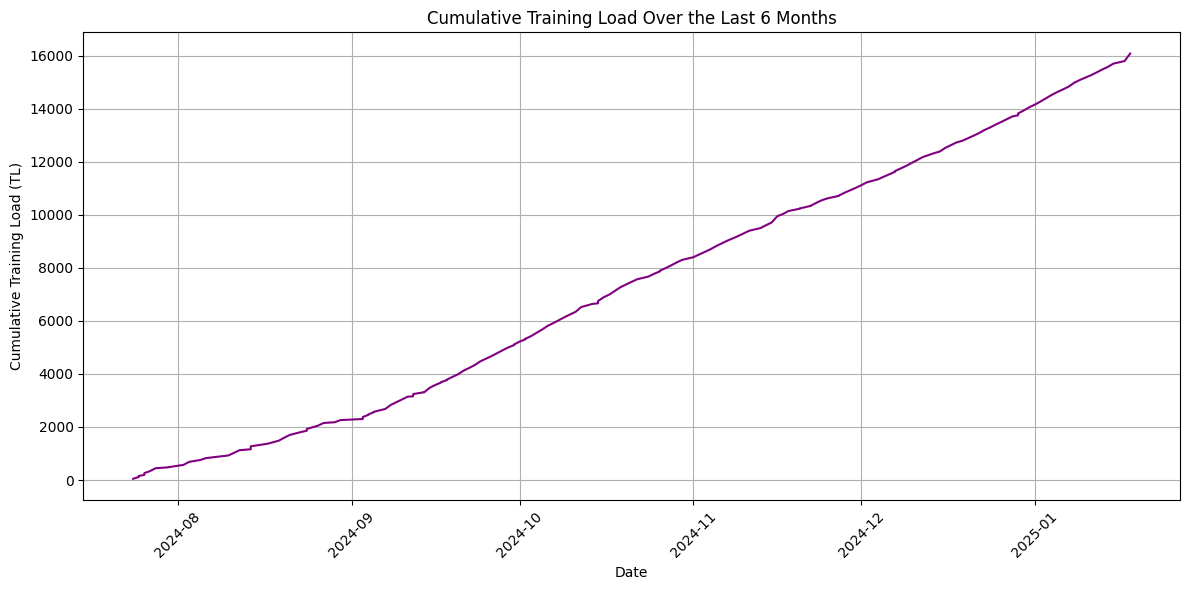

In [78]:
# Assuming you already have a dataframe df with 'Date', 'Distance', 'Pace (mph)', 'Heart Rate'
# You can add your threshold pace value (FTP) here
threshold_pace = 7.2  # e.g., threshold pace of 6 mph (adjust according to your actual pace)

# Filter the data to include only the last 6 months
six_months_ago = pd.to_datetime('today') - pd.DateOffset(months=6)
df_last_6_months = df[df['Date'] >= six_months_ago]
df_last_6_months = df_last_6_months.copy()

# Function to calculate TSS (Training Stress Score)
def calculate_tss(distance, pace, duration, threshold_pace):
    intensity_factor = pace / threshold_pace  # Calculate intensity factor based on pace
    tss = (duration * intensity_factor) * 100  # TSS formula
    return tss

# Calculate Duration (time in hours) for each row in the dataframe
df_last_6_months['Duration'] = df_last_6_months['Distance'] / df_last_6_months['Pace (mph)']

# Calculate TSS for each run
df_last_6_months['TSS'] = df_last_6_months.apply(lambda row: calculate_tss(row['Distance'], row['Pace (mph)'], row['Duration'], threshold_pace), axis=1)

# Calculate the 7-day (ATL) and 28-day (CTL) rolling averages of TSS
df_last_6_months['ATL'] = df_last_6_months['TSS'].rolling(window=7).mean()
df_last_6_months['CTL'] = df_last_6_months['TSS'].rolling(window=28).mean()
# Calculate cumulative training load (sum of TSS values)
df_last_6_months['Cumulative TL'] = df_last_6_months['TSS'].cumsum()

# Plot Cumulative Training Load
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Cumulative TL'], label='Cumulative Training Load', color='purple')
plt.title('Cumulative Training Load Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Cumulative Training Load (TL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

<h3 id="acute-chronic-training-load">Acute and Chronic Training Load</h3>


**Acute Training Load (ATL)** and **Chronic Training Load (CTL)** are values that measure the impact of your training over different time frames.

- **ATL (Acute Training Load)**: The 7-day rolling average of TSS, providing an indication of how hard your recent workouts have been.
  
- **CTL (Chronic Training Load)**: The 28-day rolling average of TSS, reflecting long-term fitness and consistency in your training regimen.

Together, ATL and CTL help you understand how your body is adapting to your training and whether you're at risk of overtraining or undertraining.

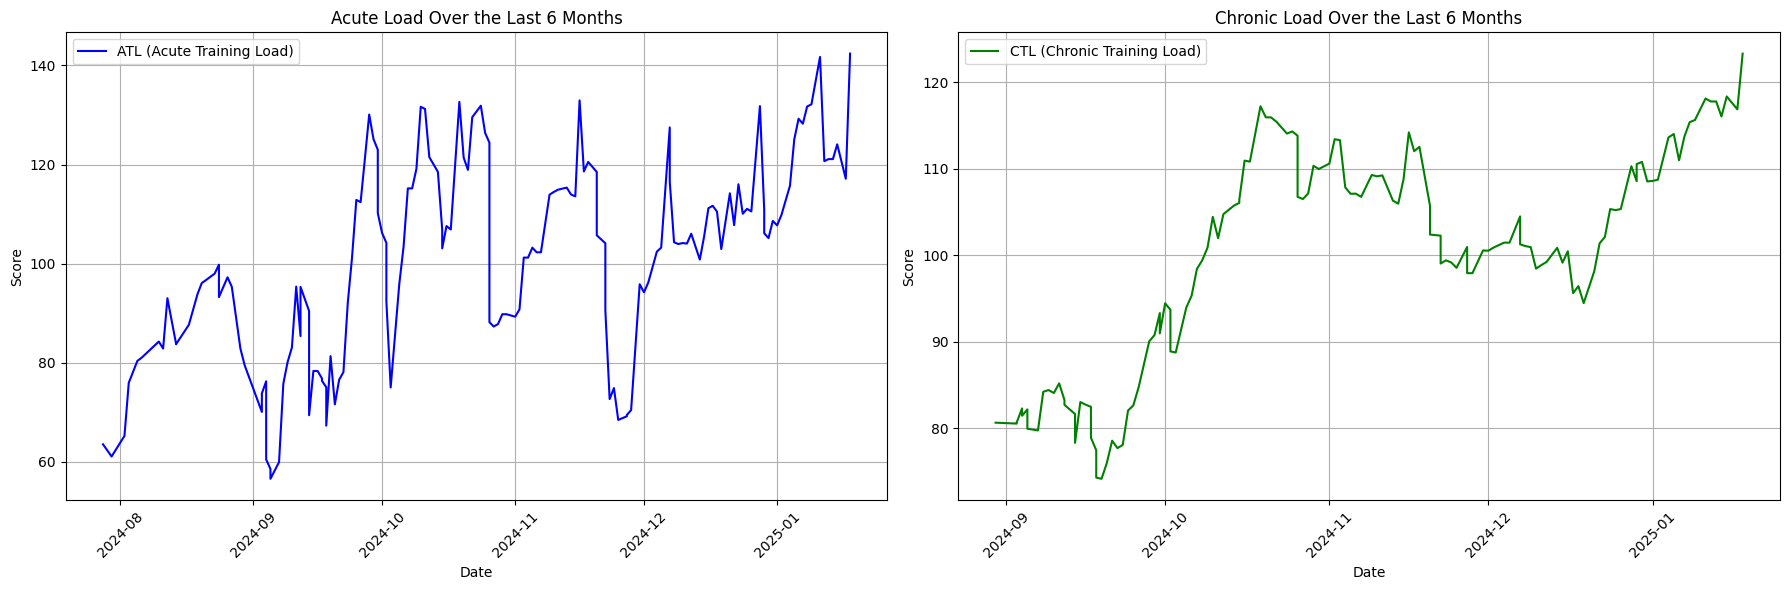

In [105]:
# Create subplots for ATL and CTL
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot Acute Training Load (ATL) on the first axis (ax[0])
axes[0].plot(df_last_6_months['Date'], df_last_6_months['ATL'], label='ATL (Acute Training Load)', color='blue')
axes[0].set_title('Acute Load Over the Last 6 Months')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Plot Chronic Training Load (CTL) on the second axis (ax[1])
axes[1].plot(df_last_6_months['Date'], df_last_6_months['CTL'], label='CTL (Chronic Training Load)', color='green')
axes[1].set_title('Chronic Load Over the Last 6 Months')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Score')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


<h3 id="stress-rest-ratio">Stress/Rest Ratio</h3>

This can be calculated as the ratio of the acute load (ATL) to chronic load (CTL). It provides an indication of how well-balanced my training and recovery are. A high ATL/CTL ratio might indicate I am not recovering enough and could be at risk for overtraining.

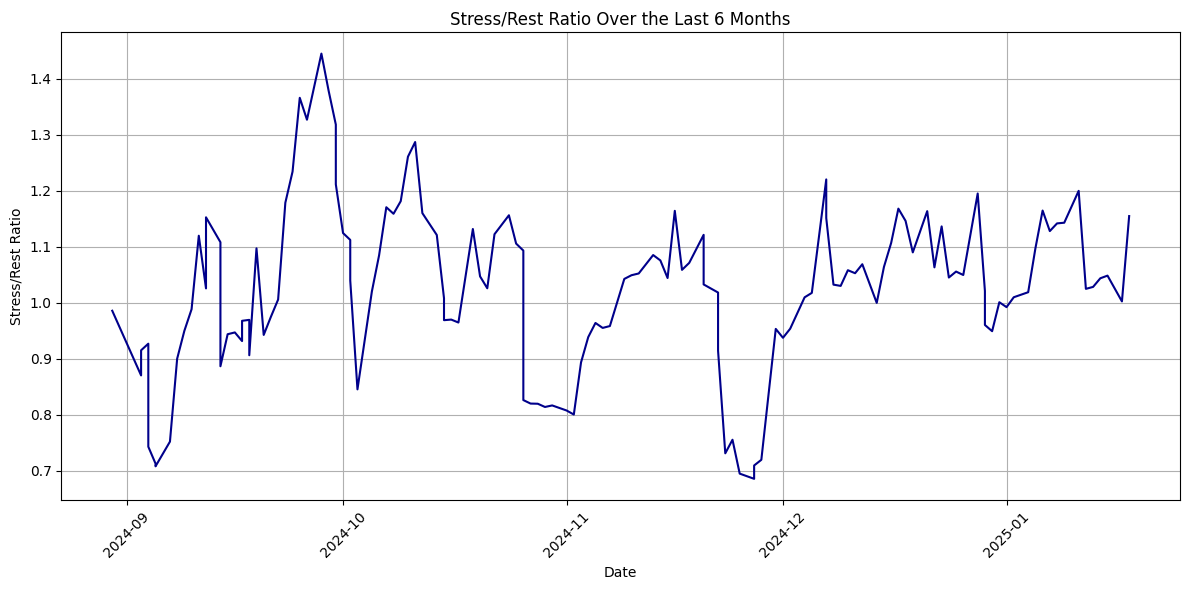

In [81]:
# Calculate Stress/Rest ratio
df_last_6_months['Stress/Rest Ratio'] = df_last_6_months['ATL'] / df_last_6_months['CTL']

# Plot Stress/Rest Ratio
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Stress/Rest Ratio'], label='Stress/Rest Ratio', color='darkblue')
plt.title('Stress/Rest Ratio Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Stress/Rest Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

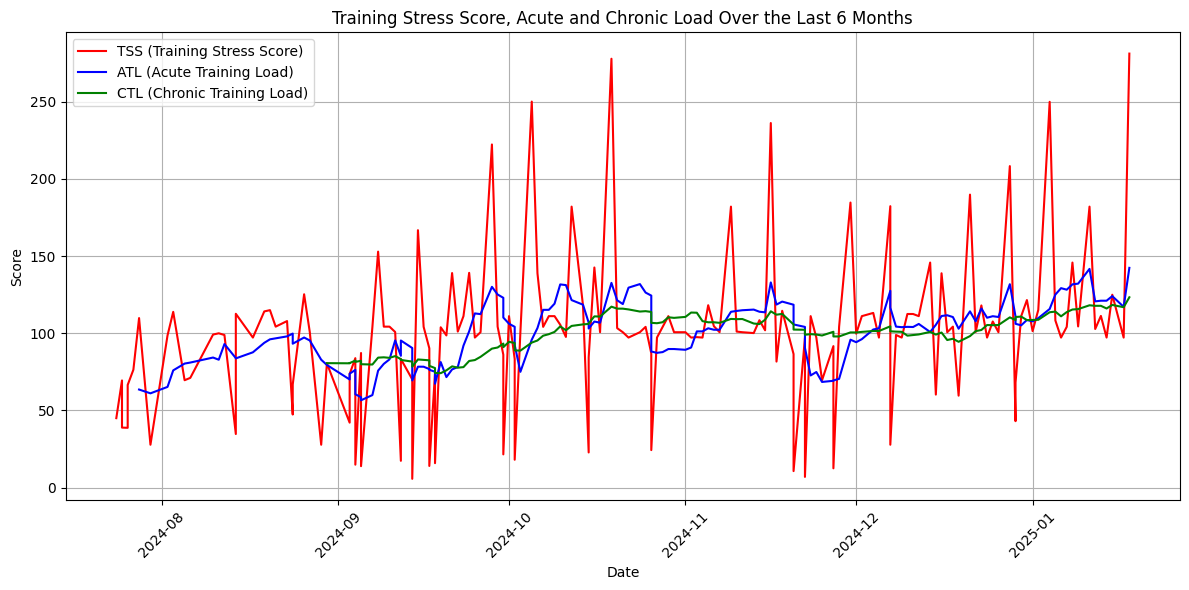

In [82]:
# Plot the TSS, ATL, and CTL over time for the last 6 months
plt.figure(figsize=(12, 6))

plt.plot(df_last_6_months['Date'], df_last_6_months['TSS'], label='TSS (Training Stress Score)', color='red')
plt.plot(df_last_6_months['Date'], df_last_6_months['ATL'], label='ATL (Acute Training Load)', color='blue')
plt.plot(df_last_6_months['Date'], df_last_6_months['CTL'], label='CTL (Chronic Training Load)', color='green')

plt.title('Training Stress Score, Acute and Chronic Load Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


<h3 id="intensity-factor-if">Intensity Factor (IF)</h3>


The **Intensity Factor (IF)** is a metric used to express the intensity of a workout relative to your threshold. It provides a more specific measure of how hard the workout was compared to your typical capability. For runners, the Intensity Factor is calculated as:

$$
IF = \frac{{\text{Actual Pace}}}{{\text{Threshold Pace}}}
$$

Where:

- **Actual Pace**: The pace at which you completed the workout.
- **Threshold Pace**: The pace you can sustain for about an hour at maximum effort (typically your Functional Threshold Pace or FTP).

The **Intensity Factor** helps you understand how much you're pushing yourself during a workout compared to your usual running capability, offering a clearer picture of your effort levels. A higher IF indicates a more intense workout, while a lower IF suggests a workout that is closer to your normal pace.


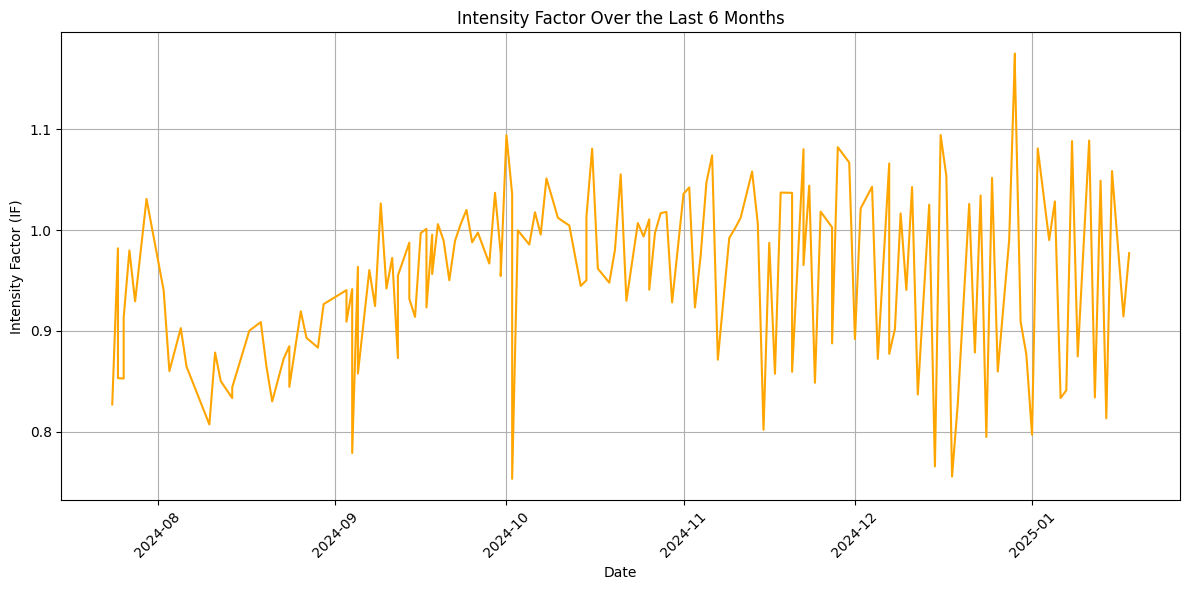

In [83]:
threshold_pace = 7.2

# Calculate Intensity Factor (IF)
df_last_6_months['Intensity Factor'] = df_last_6_months['Pace (mph)'] / threshold_pace

# Plot IF over time
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Intensity Factor'], label='Intensity Factor (IF)', color='orange')
plt.title('Intensity Factor Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Intensity Factor (IF)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


### Training Peaks
Peaks will help me spot high-intensity sessions that may require more recovery.

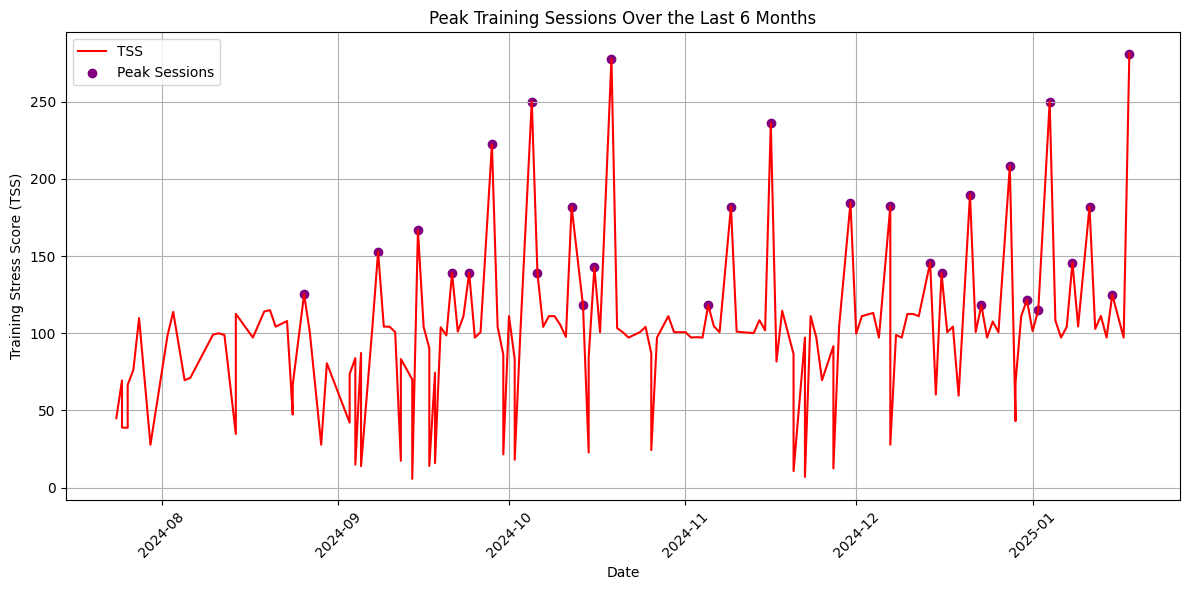

In [84]:
# Define a threshold for peak training sessions (e.g., TSS > 100)
peak_sessions = df_last_6_months[df_last_6_months['TSS'] > 115]

# Plot peak sessions
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['TSS'], label='TSS', color='red')
plt.scatter(peak_sessions['Date'], peak_sessions['TSS'], color='purple', label='Peak Sessions')
plt.title('Peak Training Sessions Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Training Stress Score (TSS)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

#### Peak Training Sessions within the 30 Days

In [108]:
today = pd.to_datetime('today')  # Get today's date
past_30_days = today - pd.Timedelta(days=30)  # Calculate the date 30 days ago

# Filter the DataFrame for sessions in the past 30 days
recent_sessions = peak_sessions[peak_sessions['Date'] >= past_30_days]

 # Convert the DataFrame to HTML and wrap it in a centered div
html_table = (recent_sessions[['Date', 'Title', 'TSS', 'Distance', 'Pace (min/mile)', 'Heart Rate']].iloc[::-1]).to_html(classes='dataframe', index=False)
centered_html = f"""
<div style="text-align: center;">
    {html_table}
</div>
"""

# Display the centered DataFrame
display(HTML(centered_html))

Date,Title,TSS,Distance,Pace (min/mile),Heart Rate
2025-01-18,Lose My Mind,281.250000,20.25,8:31,170
2025-01-15,Rock Your Body,125.000000,9.00,7:52,181
2025-01-11,Afraid to Feel,182.083333,13.11,7:39,184
2025-01-08,Barbra Streisand,145.833333,10.50,7:39,180
2025-01-04,Wins & Loses,250.000000,18.00,8:24,173
2025-01-02,Cheeky Progression🙂,115.138889,8.29,7:42,178
2024-12-31,400m x 10,121.527778,8.75,9:30,167
2024-12-28,Why is it 80 and sunny in december?,208.333333,15.00,8:24,184


### Machine Learning Analysis

#### Clustering Analysis

The graph visually clusters my runs into distinct training categories based on distance and pace. Each cluster, such as "Moderate Distance Effort Tempo Sessions" or "Long Runs," helps identify patterns in my training and ensures a balanced approach to improving both speed and endurance. 

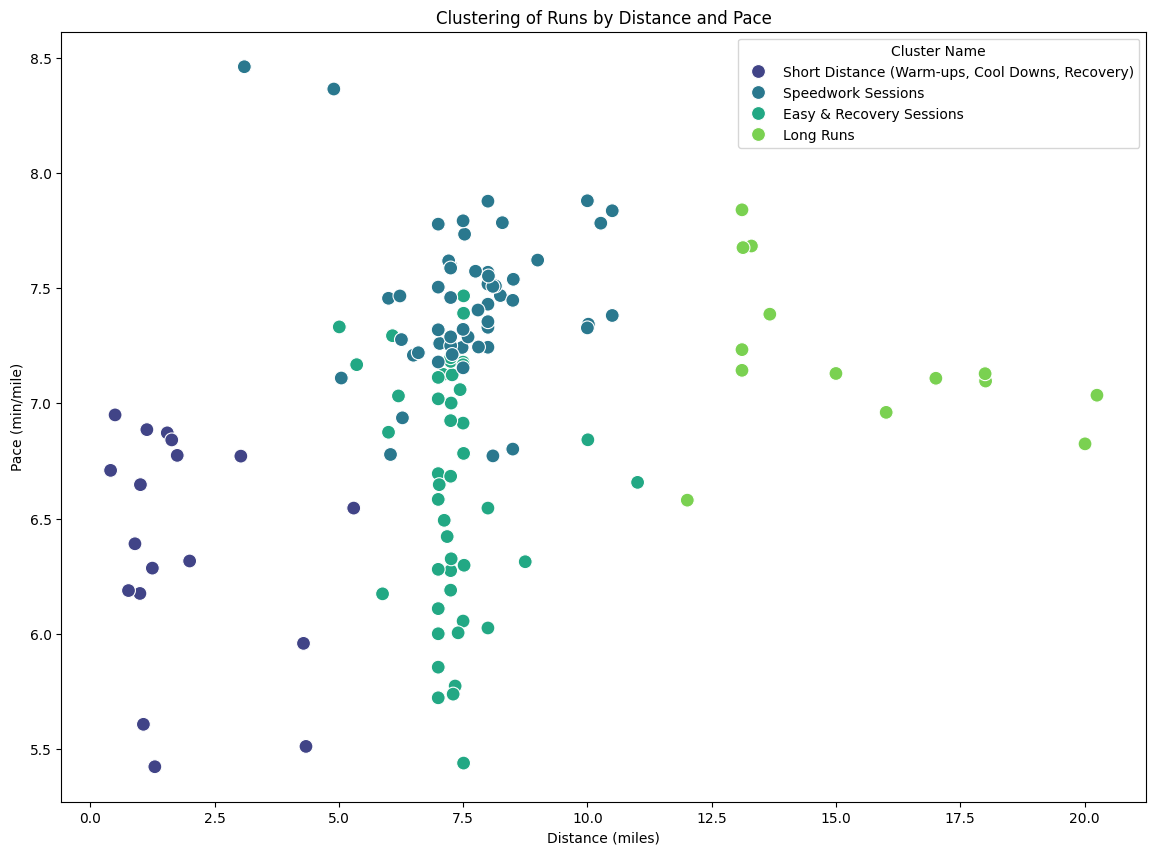

In [86]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Retain the Date column for later use
columns_to_drop = ['Sport', 'Title', 'Time', 'Pace', 'Pace (min/mile)', 'Cleaned Time']  # Columns to drop

# Filter out rows before September 1st
september_start = pd.to_datetime('2024-09-01')
df_since_september = df[df['Date'] >= september_start]

# Ensure that 'Date' column is preserved and cleaned data is prepared
df_cleaned = df_since_september.drop(columns=columns_to_drop, errors='ignore')

# Normalize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned.drop(columns='Date', errors='ignore'))  # Dropping 'Date' temporarily

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(df_scaled)

# Mapping between cluster numbers and names
cluster_mapping = {
    0: "Easy & Recovery Sessions",
    1: "Long Runs",
    2: "Short Distance (Warm-ups, Cool Downs, Recovery)",
    3: "Speedwork Sessions"
}

# Reverse mapping for quick lookup by name
name_to_cluster = {v: k for k, v in cluster_mapping.items()}
df_cleaned['Cluster Name'] = df_cleaned['Cluster'].map(cluster_mapping)

# Group by Date and Cluster, calculate the mean for the relevant columns (Distance)
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])  # Ensure 'Date' is in datetime format

# Grouping by Date and Cluster to compute the average distance per cluster over time
trend_analysis = df_cleaned.groupby(['Date', 'Cluster'])['Distance'].mean().reset_index()

# Plot the clusters
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df_cleaned, x='Distance', y='Pace (mph)', hue='Cluster Name', palette='viridis', s=100)
plt.title("Clustering of Runs by Distance and Pace")
plt.xlabel("Distance (miles)")
plt.ylabel("Pace (min/mile)")
plt.legend(title="Cluster Name")
plt.show()

The elbow method is a technique used to determine the optimal number of clusters in a dataset by plotting the within-cluster sum of squares (WCSS) against the number of clusters. The "elbow point," where the rate of decrease in WCSS sharply changes, indicates the most appropriate number of clusters for the data.

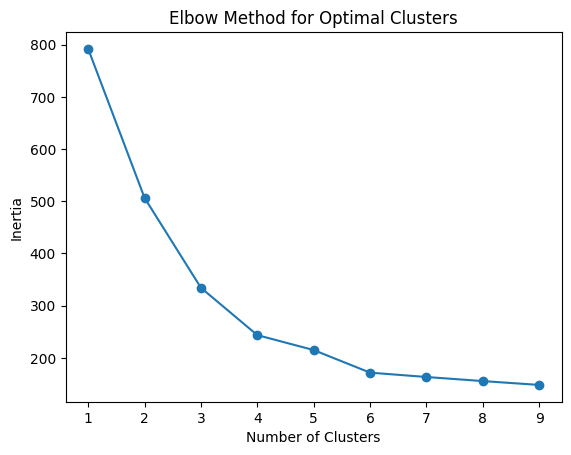

In [87]:
# Elbow Method
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

The elbow method indicates that adding 5 or more clusters results in diminishing returns on inertia reduction. As the number of clusters increases, the decrease in inertia becomes less significant, suggesting that a model with 5 to 6 clusters strikes the optimal balance between accuracy and simplicity. This range provides a sufficient level of granularity without introducing unnecessary complexity.

#### Summary of Cluster Types and Statistics

In [88]:
# Group by cluster and calculate aggregate statistics
cluster_summary = df_cleaned.groupby('Cluster').agg({
    'Cluster Name': 'first',  # Use 'first' to include the cluster name
    'Distance': ['mean', 'std', 'min', 'max'],
    'Pace (mph)': ['mean', 'std', 'min', 'max'],
    'Heart Rate': ['mean', 'std', 'min', 'max'],
}).reset_index()

# Rename columns for clarity 
cluster_summary.columns = ['Cluster', 'Cluster Name', 
                           'Distance Mean', 'Distance Std', 'Distance Min', 'Distance Max',
                           'Pace Mean', 'Pace Std', 'Pace Min', 'Pace Max',
                           'HR Mean', 'HR Std', 'HR Min', 'HR Max']

# Display the summary
display(cluster_summary)

,Cluster,Cluster Name,Distance Mean,Distance Std,Distance Min,Distance Max,Pace Mean,Pace Std,Pace Min,Pace Max,HR Mean,HR Std,HR Min,HR Max
0,0,Easy & Recovery Sessions,7.262174,0.953906,5.01,11.01,6.619291,0.527759,5.438745,7.466446,159.130435,6.420830,145,170
1,1,Long Runs,15.409286,2.790780,12.01,20.25,7.201877,0.345017,6.579820,7.839867,173.428571,9.685153,157,188
2,2,"Short Distance (Warm-ups, Cool Downs, Recovery)",1.847222,1.430408,0.41,5.30,6.380489,0.490455,5.422943,6.949807,164.611111,10.472029,148,180
3,3,Speedwork Sessions,7.627778,1.360700,3.10,10.50,7.443733,0.321435,6.771946,8.460955,176.944444,7.050804,163,189


In [89]:
# # Boxplot for pace across clusters
# plt.figure(figsize=(8, 6))
# df_cleaned.boxplot(column='Pace (mph)', by='Cluster', grid=False)
# plt.title('Pace (min/mile) Distribution by Cluster')
# plt.suptitle('')  # Removes the default title
# plt.xlabel('Cluster')
# plt.ylabel('Pace (mph)')
# plt.show()

# # Boxplot for pace across clusters
# plt.figure(figsize=(8, 6))
# df_cleaned.boxplot(column='Distance', by='Cluster', grid=False)
# plt.title('Distance Distribution by Cluster')
# plt.suptitle('')  # Removes the default title
# plt.xlabel('Cluster')
# plt.ylabel('Distance')
# plt.show()


In [90]:
# # Histogram for distance
# plt.figure(figsize=(10, 6))
# for cluster in df_cleaned['Cluster'].unique():
#     cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster]
#     plt.hist(cluster_data['Distance'], alpha=0.5, bins=10, label=f'Cluster {cluster}')

# plt.xlabel('Distance (miles)')
# plt.ylabel('Frequency')
# plt.title('Distance Distribution by Cluster')
# plt.legend()
# plt.show()


In [91]:
# Correlation matrix for a specific cluster
for cluster in df_cleaned['Cluster'].unique():
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster]
    correlation_matrix = cluster_data[['Distance', 'Pace (mph)']].corr()
    # print(f"Correlation Matrix for Cluster {cluster}:\n", correlation_matrix)


#### Pace Progression Over Time 

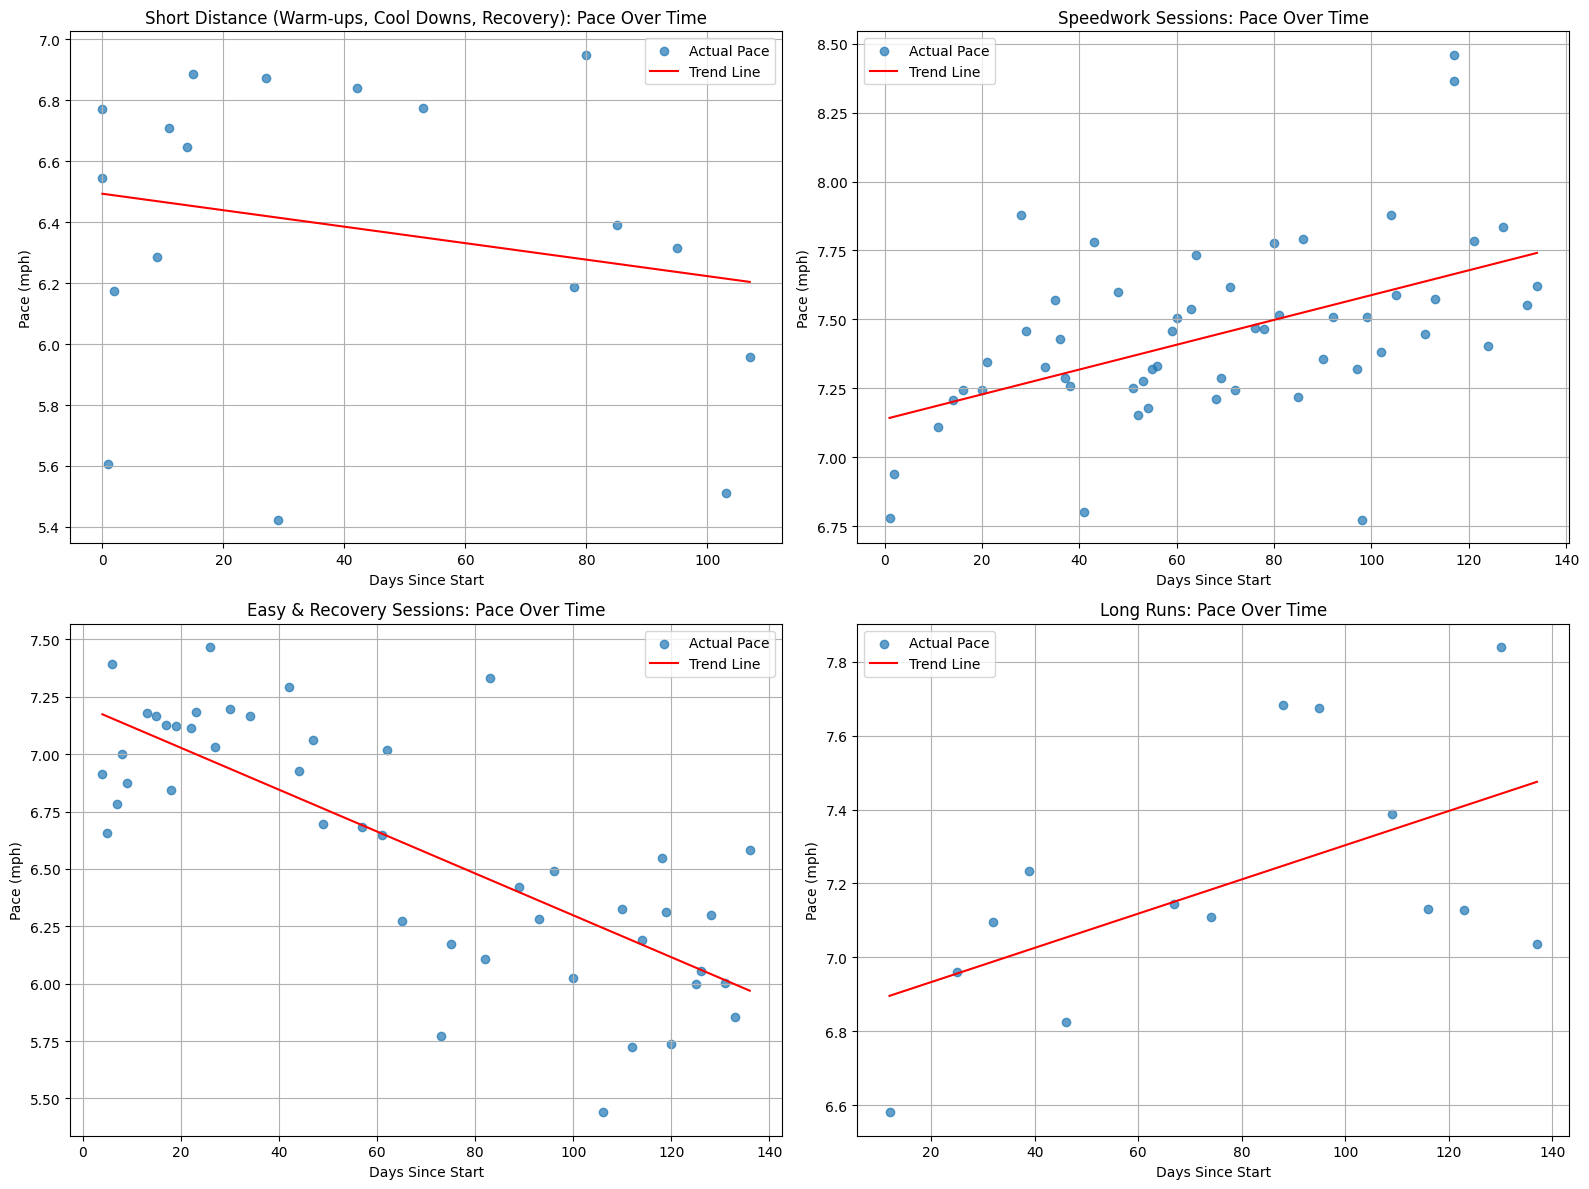

In [110]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Ensure the Date column is in datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Convert dates to numerical format (e.g., days since the start)
start_date = df_cleaned['Date'].min()
df_cleaned['Days Since Start'] = (df_cleaned['Date'] - start_date).dt.days

# Prepare for storing regression results
time_analysis_results = {}

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to easily index for each cluster plot

# Iterate over each cluster
for idx, cluster in enumerate(df_cleaned['Cluster'].unique()):
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster]
    X = cluster_data[['Days Since Start']].values  # Predictor (time)
    y = cluster_data['Pace (mph)'].values  # Target (pace)
    
    # Fit the regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Store regression coefficients
    time_analysis_results[cluster] = {
        'coefficient': model.coef_[0],
        'intercept': model.intercept_,
        'R^2': model.score(X, y)
    }
    
    # Generate predictions and update the original DataFrame
    df_cleaned.loc[cluster_data.index, 'Predicted Pace Over Time'] = model.predict(X)
    
    # Plot on the corresponding axis (ax[idx])
    axes[idx].scatter(cluster_data['Days Since Start'], cluster_data['Pace (mph)'], label='Actual Pace', alpha=0.7)
    axes[idx].plot(cluster_data['Days Since Start'], model.predict(X), color='red', label='Trend Line')
    axes[idx].set_title(f'{cluster_mapping[cluster]}: Pace Over Time')
    axes[idx].set_xlabel('Days Since Start')
    axes[idx].set_ylabel('Pace (mph)')
    axes[idx].legend()
    axes[idx].grid()

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

#### Heart Rate Progression Over Time 

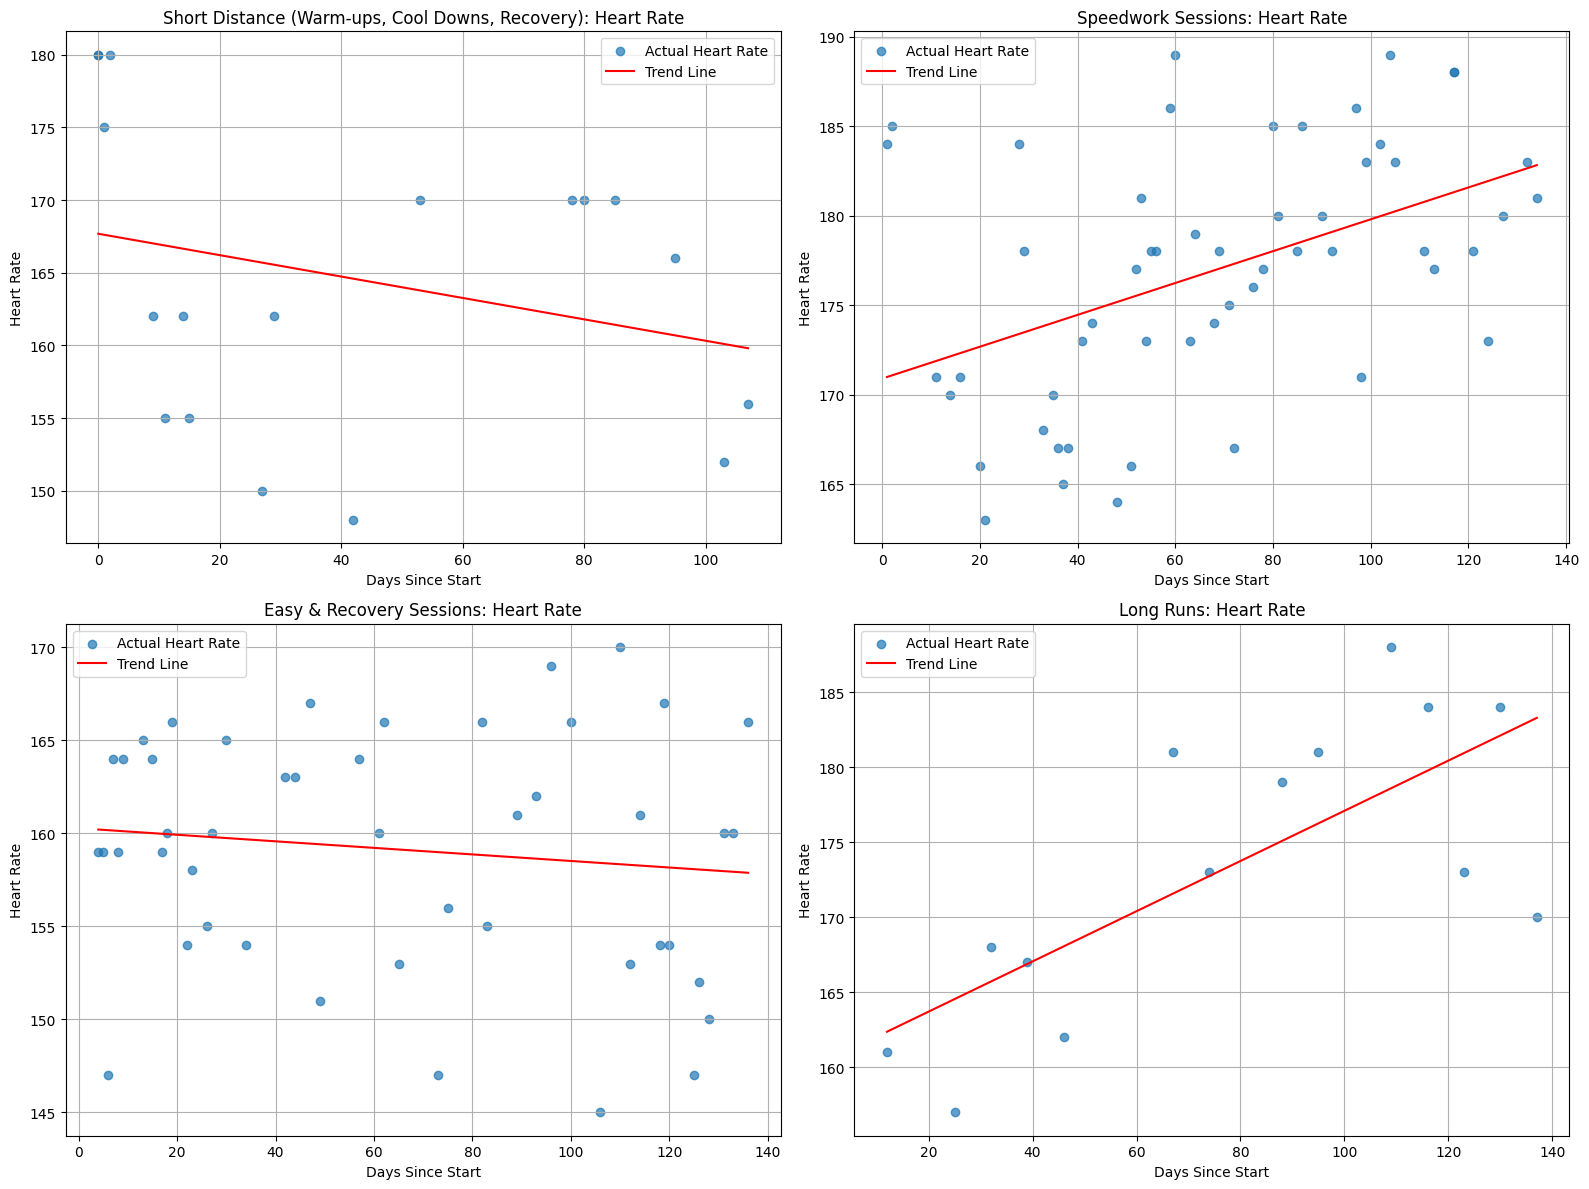

In [111]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Prepare for storing regression results
time_analysis_results = {}

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to easily index for each cluster plot

# Iterate over each cluster
for idx, cluster in enumerate(df_cleaned['Cluster'].unique()):
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster]
    X = cluster_data[['Days Since Start']].values  # Predictor (time)
    y = cluster_data['Heart Rate'].values  # Target (heart rate)
    
    # Fit the regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Store regression coefficients
    time_analysis_results[cluster] = {
        'coefficient': model.coef_[0],
        'intercept': model.intercept_,
        'R^2': model.score(X, y)
    }
    
    # Generate predictions and update the original DataFrame
    df_cleaned.loc[cluster_data.index, 'Predicted Heart Rate Over Time'] = model.predict(X)
    
    # Plot on the corresponding axis (ax[idx])
    axes[idx].scatter(cluster_data['Days Since Start'], cluster_data['Heart Rate'], label='Actual Heart Rate', alpha=0.7)
    axes[idx].plot(cluster_data['Days Since Start'], model.predict(X), color='red', label='Trend Line')
    axes[idx].set_title(f'{cluster_mapping[cluster]}: Heart Rate')
    axes[idx].set_xlabel('Days Since Start')
    axes[idx].set_ylabel('Heart Rate')
    axes[idx].legend()
    axes[idx].grid()

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()


#### Distance vs Pace with Heart Rate Color Mapping

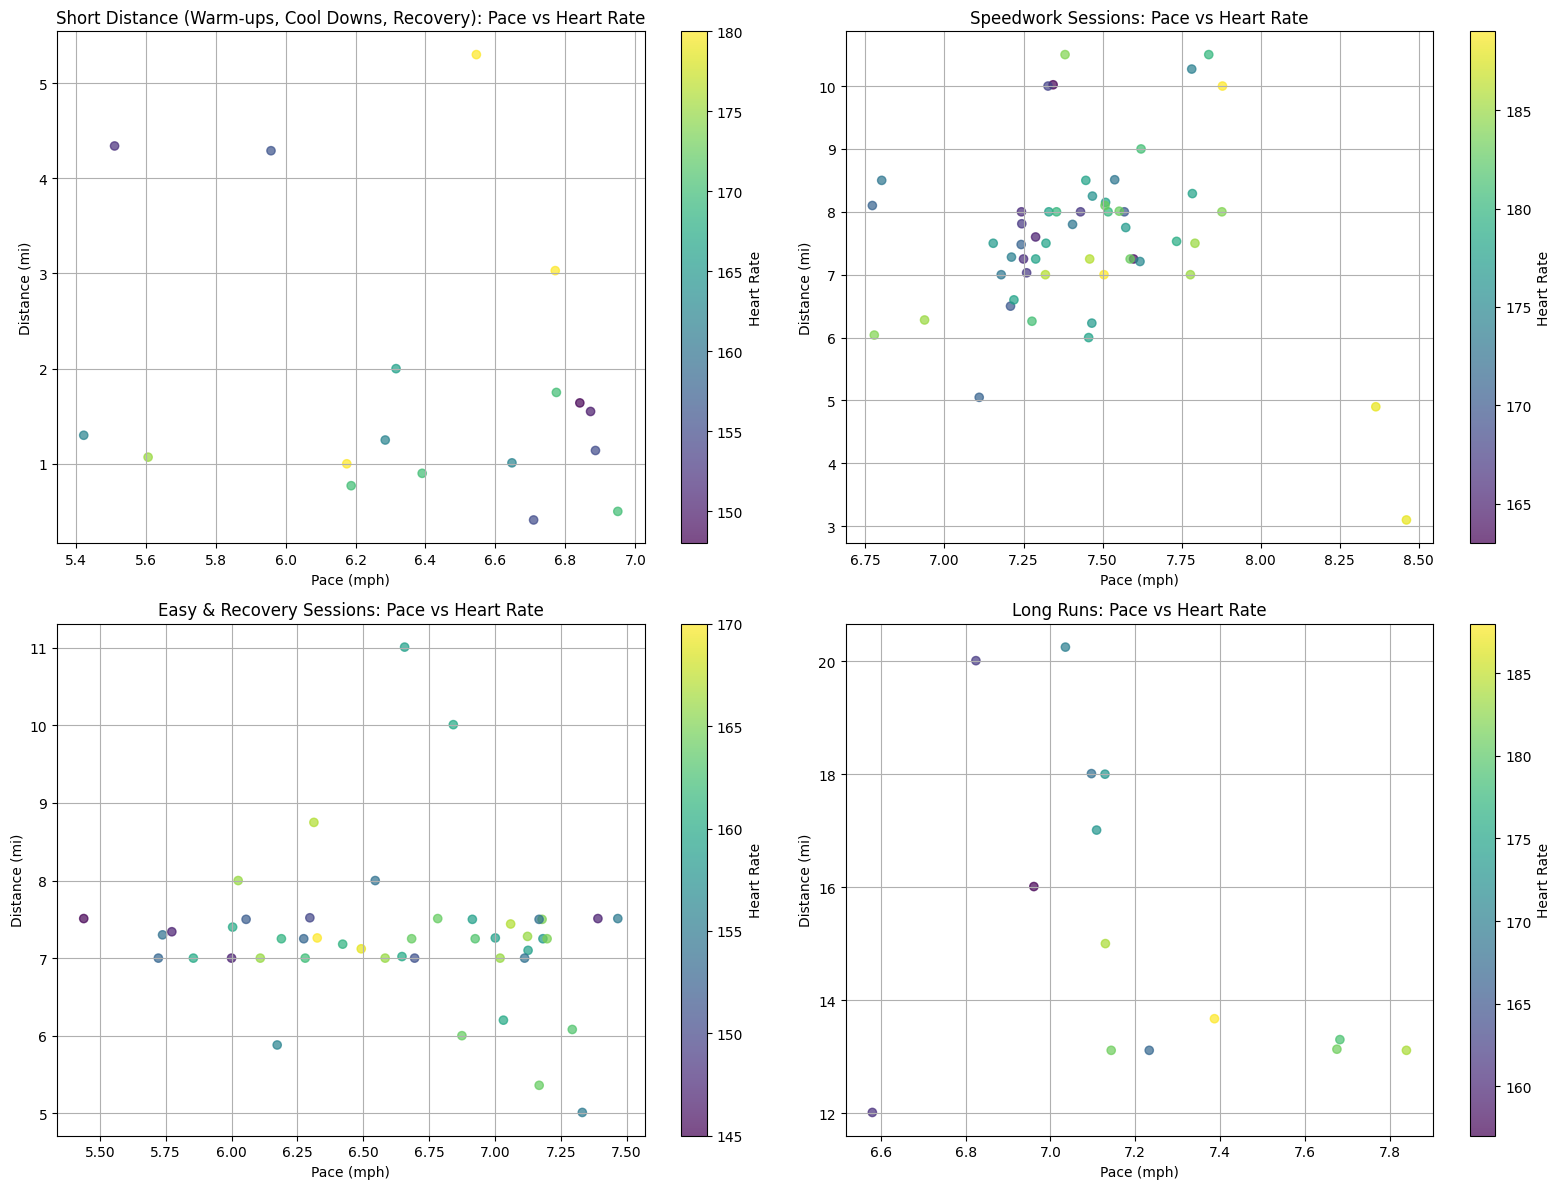

In [112]:
import matplotlib.pyplot as plt

# Set number of columns to 2
cols = 2
# Calculate the number of rows (in this case, 2 rows to accommodate up to 4 plots)
num_clusters = len(df_cleaned['Cluster'].unique())
rows = 2  # We want 2 rows

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))  # Adjust figsize to fit the plots

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each cluster and plot on the corresponding axis
for idx, cluster in enumerate(df_cleaned['Cluster'].unique()):
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster]
    
    # Scatter plot with heart rate as color
    sc = axes[idx].scatter(cluster_data['Pace (mph)'], cluster_data['Distance'], 
                           alpha=0.7, c=cluster_data['Heart Rate'], cmap='viridis')
    
    # Add color bar and labels
    fig.colorbar(sc, ax=axes[idx], label='Heart Rate')
    axes[idx].set_title(f'{cluster_mapping[cluster]}: Pace vs Heart Rate')
    axes[idx].set_xlabel('Pace (mph)')
    axes[idx].set_ylabel('Distance (mi)')
    axes[idx].grid()

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined subplots
plt.show()
